# Data Modelling

In [14]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Pyspark Modelling") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.csv('Data/Cleaned_data.csv', header= True, inferSchema= True, multiLine=True, quote='"', escape='"')
df.printSchema()

root
 |-- Desc: string (nullable = true)
 |-- hostID: integer (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- host_listings: integer (nullable = true)
 |-- availability: integer (nullable = true)
 |-- city: string (nullable = true)



In [15]:
# importing libraries

import numpy as np
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

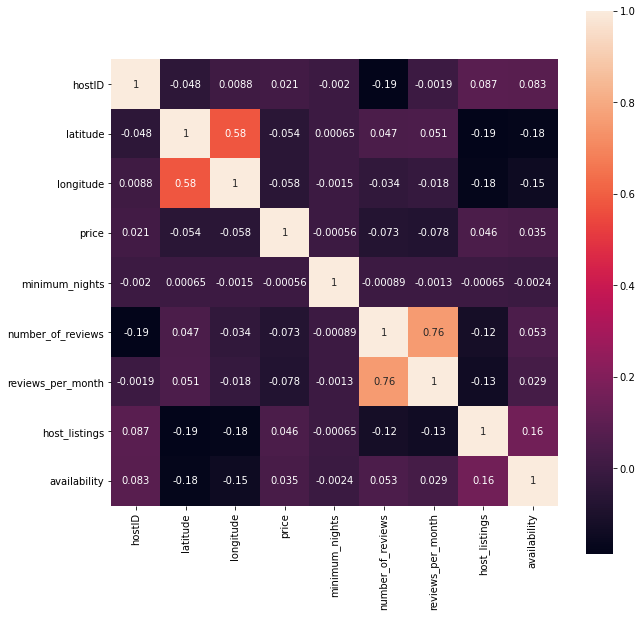

In [16]:
dfp = df.toPandas()
corr_matrix = dfp.corr("pearson")
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, annot=True)
plt.savefig('Figures/correlation_matrix.png')

In [17]:
#log transformation of non-uniform continuous featrures
log_features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'host_listings']

In [18]:
def log_func(dataframe, names):
    for name in names: 
        dataframe = dataframe.withColumn(name, F.log1p(name))
    return dataframe 
df_log = log_func(df, log_features)

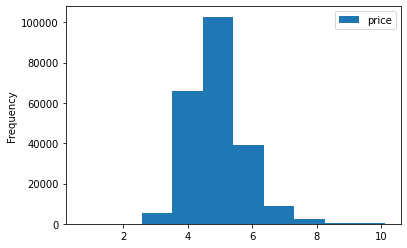

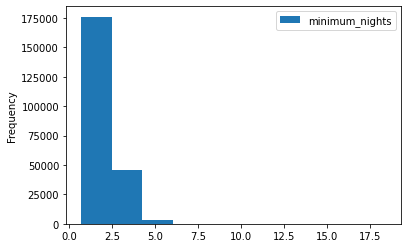

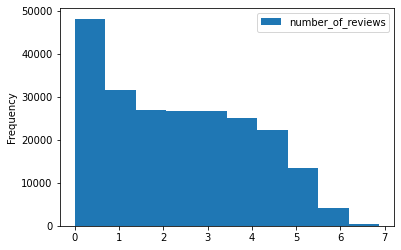

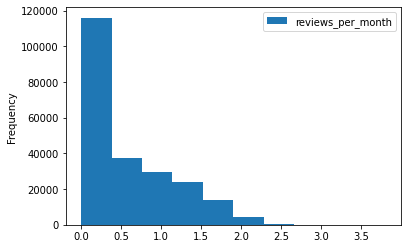

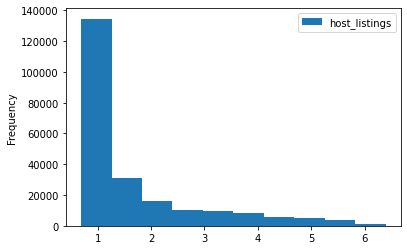

In [19]:
for features in log_features:
    x = df_log.select(features).toPandas() 
    x.plot(kind='hist')

In [20]:
df_model = df_log.drop(*['hostID', 'Desc'])
df_model.count()

225610

In [21]:
Cat_features = ['neighbourhood_group', 'room_type', 'city']
Cont_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'host_listings', 'availability']

In [22]:
#label encoding of categorical features
from pyspark.ml.feature import StringIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator

stages = [] # stages in our Pipeline
for categoricalCol in Cat_features:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in Cat_features] + Cont_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [23]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_model)
model = pipelineModel.transform(df_model)
model.take(1)

[Row(neighbourhood_group='Unknown', latitude=35.60418, longitude=-82.54964, room_type='Entire home/apt', price=5.081404364984463, minimum_nights=3.4339872044851463, number_of_reviews=4.248495242049359, reviews_per_month=1.1786549963416462, host_listings=0.6931471805599453, availability=161, city='Asheville', neighbourhood_groupIndex=0.0, neighbourhood_groupclassVec=SparseVector(33, {0: 1.0}), room_typeIndex=0.0, room_typeclassVec=SparseVector(3, {0: 1.0}), cityIndex=22.0, cityclassVec=SparseVector(27, {22: 1.0}), features=SparseVector(70, {0: 1.0, 33: 1.0, 58: 1.0, 63: 35.6042, 64: -82.5496, 65: 3.434, 66: 4.2485, 67: 1.1787, 68: 0.6931, 69: 161.0}))]

In [24]:
from pyspark.ml.linalg import DenseVector
input_data = model.rdd.map(lambda x: (x['price'], DenseVector(x['features']))).toDF(['label', 'features'])
input_data.show(2)

+-----------------+--------------------+
|            label|            features|
+-----------------+--------------------+
|5.081404364984463|[1.0,0.0,0.0,0.0,...|
|4.110873864173311|[1.0,0.0,0.0,0.0,...|
+-----------------+--------------------+
only showing top 2 rows



In [25]:
# Split the data into train and test sets
train_data, test_data = input_data.randomSplit([0.8,0.2],seed=1234)

# Linear Regression

In [26]:
# Import `LinearRegression`
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="label",featuresCol="features")
linearModel = lr.fit(train_data)

In [27]:
# Making predictions on test data using the transform() method.
predictions = linearModel.transform(test_data)

In [28]:
predictions.printSchema()
selected = predictions.select("label", "prediction")
selected.show(2)

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
|0.6931471805599453|4.5547972057102015|
|0.6931471805599453| 4.611066425184262|
+------------------+------------------+
only showing top 2 rows



In [30]:
#Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
import sklearn.metrics

# Selecting (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",predictionCol="prediction",metricName="rmse")
rmse_lr = evaluator.evaluate(predictions)
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
r2_lr = sklearn.metrics.r2_score(y_true, y_pred)

print("Root Mean Squared Error: ", rmse_lr)
print("R2 score: ", r2_lr)

Root Mean Squared Error:  0.6747780308163133
R2 score:  0.35669096627817476


# Ridge regression

In [31]:
from pyspark.ml.regression import LinearRegression

rlr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100,
regParam=0.1, elasticNetParam=0.0, fitIntercept=True, standardization=True)
linearModel = rlr.fit(train_data)


In [32]:
# Making predictions on test data using the transform() method.
predictions = linearModel.transform(test_data)

In [33]:
#Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
import sklearn.metrics

# Selecting (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",predictionCol="prediction",metricName="rmse")
rmse_rr = evaluator.evaluate(predictions)
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
r2_rr = sklearn.metrics.r2_score(y_true, y_pred)

print("Root Mean Squared Error: ", rmse_rr)
print("R2 score: ", r2_rr)

Root Mean Squared Error:  0.6785292014785422
R2 score:  0.34951862399804


# Random Forest

In [36]:
from pyspark.ml.regression import RandomForestRegressor
 
(training_data, test_data) = input_data.randomSplit([0.7, 0.3], 2017)
rf= RandomForestRegressor(labelCol = "label", featuresCol = "features", numTrees = 20)
rf_model = rf.fit(training_data)

Exception ignored in: <function JavaWrapper.__del__ at 0x00000057342C7558>
Traceback (most recent call last):
  File "C:\Users\Haier\Desktop\spark\spark-2.4.7-bin-hadoop2.7\python\pyspark\ml\wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestRegressor' object has no attribute '_java_obj'


In [37]:
predictions = rf_model.transform(test_data)

In [38]:
#Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
import sklearn.metrics

# Selecting (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",predictionCol="prediction",metricName="rmse")
rmse_rf = evaluator.evaluate(predictions)
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
r2_rf = sklearn.metrics.r2_score(y_true, y_pred)

print("Root Mean Squared Error: ", rmse_rf)
print("R2 score: ", r2_rf)

Root Mean Squared Error:  0.6791891763283193
R2 score:  0.3496457282912778
